In [1]:
import sys, os, math
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
train_list = pd.read_csv('../Data/training.txt', header=None)
train_list.columns=['trackfile','typing']

In [3]:
train_list.head()

,trackfile,typing
0,100047,trawler
1,100070,longliner
2,100080,seiner
3,100093,other
4,100144,trawler


In [4]:
y_class = train_list['typing'].unique().tolist(); y_class

['trawler', 'longliner', 'seiner', 'other', 'support']

In [5]:
y1 = np.array([0,1,8])
y2 = np.array(['0','1','3'])
y3 = np.array([0])
yy = np.empty(3,dtype=object)
yy[0]=y1
yy[1]=y2
yy[2]=y3
yy
#yy[0] = ([0,1,2,3])

array([array([0, 1, 8]), array(['0', '1', '3'],
      dtype='|S1'),
       array([0])], dtype=object)

In [91]:
max_features = 512

ii, x_train, y_train = 0, np.empty((len(train_list)),dtype=object), []
x_train = np.zeros((len(train_list),max_features))
z_train = np.zeros((len(train_list),max_features))
a_train = np.zeros((len(train_list),max_features))
b_train = np.zeros((len(train_list),max_features))
c_train = np.zeros((len(train_list),max_features))

tt_len, tt_time = [], []

for ii,ffile in enumerate((train_list['trackfile'].values.tolist())): # [:10]) :
    xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
    xx['Time']  = xx[[1]]
    xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
    xx['hTime'] = xx.sTime/3600.0
    xx['Depth'] = xx[[5]]
    
    havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    havLo       = (0.5*(1.0-np.cos(-xx.Longitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    
    cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)
    
    hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
    dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)
    
    xx['Distance'] = dist
    xx['Speed']    = (dist/1.852/xx.hTime).fillna(0.0)
    
    if (ii==0) : trackAll = xx.copy()
    else : trackAll = trackAll.append(xx.copy())
        
    ##print(len(xx),len(trackAll),trackAll.shape)
    
    if 0 : 
        #print('havLa',xx.havLa.values.tolist()[:10])
        #print(xx.havLo.values.tolist()[:10])
        #print(xx.cosLa.values.tolist()[:10])
        #print(xx.cosLa.shift(-1).values.tolist()[:10])
        #print('temp',temp.values.tolist()[-10:])
        #print('dist0',dist0.values.tolist()[-10:])
        print('dist',dist.values.tolist()[:20])
        #print('speed',xx.Speed.values.tolist()[:20])
        #print('SOG',xx.SOG.values.tolist()[-10:])
        print('sTime',xx.sTime.values.tolist()[:20])
        print('hTime',xx.hTime.values.tolist()[:20])
        print(zip(xx.Speed,xx.SOG)[:20])
    
    
    #xx['Distance'] = xx.sinLa*xx.sinLa.shift().fillna(0.0)+xx.cosLa*xx.cosLa.shift().fillna(0.0)*np.cos(xx.Longitude.diff().fillna(0)/180.0*math.pi).fillna(0.0)
    #xx.Speed[xx.Speed>=200.0] = 0.0
    
    x_train[ii] = np.array((xx.sTime.values.tolist()+[0.0]*max_features)[:max_features])
    z_train[ii] = np.array((xx.SOG.values.tolist()+[0.0]*max_features)[:max_features])
    a_train[ii] = np.array((xx.Depth.values.tolist()+[0.0]*max_features)[:max_features])
    b_train[ii] = np.array((xx.Speed.values.tolist()+[0.0]*max_features)[:max_features])
    c_train[ii] = np.array((xx.Distance.values.tolist()+[0.0]*max_features)[:max_features])
    
    y1          = [0]*len(y_class);  
    y1[y_class.index(train_list.typing[ii])] = 1;
    y_train.append(y1)
    
    tt_len.append(len(xx))
    tt_time.append(xx[[1]].max())
    
y_train = np.array(y_train)
tt_len  = np.array(tt_len)
tt_time = np.array(tt_time)

#print(y_train,x_train)

In [92]:
#trackAll.to_csv('../Data/trainingAll.csv',index=False)

In [6]:
trackAll = pd.read_csv('../Data/trainingAll.csv')

In [8]:
!ls -la ../Data
trackAll.shape

total 1167804
drwxrwxrwx 1 boba boba        488 авг 31 23:56 .
drwxrwxrwx 1 boba boba       4096 авг 31 04:17 ..
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  1 00:12 trainingAll.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(8080623, 20)

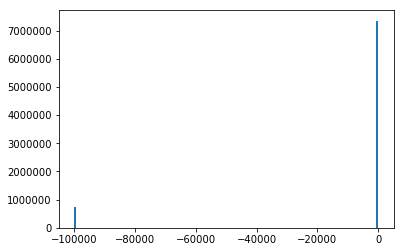

,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),TrackNumber,Water Surface Elevation,hTime,oceanic depth,sTime
0,0.3105,-4,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,34.3,10.7,6.652769,111.0,0,0,100047,-0.22,0.258611,-4.0,931.0
1,0.3043,-11,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,34.3,10.7,9.012747,109.5,931,931,100047,-0.22,0.358333,-11.0,1290.0
2,0.3059,-16,8.779740,0.06,41.043652,1.279553,0.04,NaN,10.2,34.3,10.7,10.337037,117.4,2221,2221,100047,-0.23,0.458611,-16.0,1651.0
3,0.3674,-46,0.000000,0.08,40.998603,1.365502,0.07,NaN,10.5,34.3,10.6,0.000000,123.8,3872,3872,100047,-0.24,0.000278,-46.0,1.0
4,0.3674,-46,0.000095,0.08,40.998603,1.365502,0.07,NaN,10.5,34.3,10.6,0.046135,123.8,3873,3873,100047,-0.24,0.001111,-46.0,4.0


In [9]:
if 0 :
    trackAll.Latitude.sort_values().round().unique()
    trackAll.Longitude.sort_values().round().unique()
    trackAll.SOG.sort_values().round().unique()
    trackAll.Speed.sort_values().round().unique()
    trackAll.hTime.sort_values().round().unique()
    trackAll.hTime.min(),trackAll.hTime.max()
    trackAll.Depth.sort_values().round().unique()
    #-------------------------------
    plt.hist(trackAll.SOG[(trackAll.SOG>0) & (trackAll.SOG<30)],bins=50); plt.show()
    plt.hist(trackAll.Speed[(trackAll.Speed>0) & (trackAll.Speed<30)],bins=50); plt.show()
    temp = trackAll[(trackAll.Speed>0) & (trackAll.Speed<20) & (trackAll.SOG>0) & (trackAll.SOG<20)]
    plt.hist(temp.SOG-temp.Speed,bins=100); plt.show()
    #-------------------------------
    len(trackAll.Speed[(trackAll.Speed<0) | (trackAll.Speed>40)]), len(trackAll.SOG[(trackAll.SOG<0) | (trackAll.SOG>40)])
    
    print(len(trackAll.Depth[trackAll.Depth<-1000]),len(trackAll.Depth[trackAll.Depth>100]))
    plt.hist(trackAll.Depth[trackAll.Depth>0],bins=150); plt.show()
    trackAll.TrackNumber[trackAll.Depth<0].unique().shape
    
    plt.hist(trackAll.Distance[trackAll.Distance<10],bins=150); plt.show()
    
    plt.hist(trackAll.Salinity[trackAll.Salinity>0],bins=150); plt.show()

plt.hist(trackAll['Sea Temperature'],bins=150); plt.show()
trackAll.head()

In [10]:
##train_list.head()
trainIndex=train_list.copy()
##trainIndex.head()
trainIndex['y'] = -1
for ii in range(len(trainIndex)) : 
    trainIndex.y[ii] = y_class.index(trainIndex.typing[ii])
    
trainIndex=trainIndex.set_index('trackfile')
trainIndex.head()

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,typing,y
trackfile,,
100047,trawler,0
100070,longliner,1
100080,seiner,2
100093,other,3
100144,trawler,0


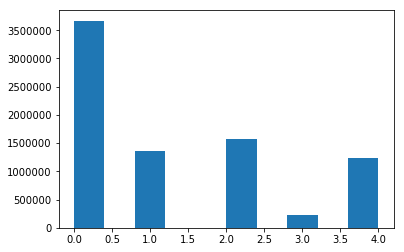

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,...,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,sTime,y
0,100047,0.3105,-4,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,...,10.7,6.652769,111.0,0,0,-0.22,0.258611,-4.0,931.0,0
1,100047,0.3043,-11,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,...,10.7,9.012747,109.5,931,931,-0.22,0.358333,-11.0,1290.0,0
2,100047,0.3059,-16,8.779740,0.06,41.043652,1.279553,0.04,NaN,10.2,...,10.7,10.337037,117.4,2221,2221,-0.23,0.458611,-16.0,1651.0,0
3,100047,0.3674,-46,0.000000,0.08,40.998603,1.365502,0.07,NaN,10.5,...,10.6,0.000000,123.8,3872,3872,-0.24,0.000278,-46.0,1.0,0
4,100047,0.3674,-46,0.000095,0.08,40.998603,1.365502,0.07,NaN,10.5,...,10.6,0.046135,123.8,3873,3873,-0.24,0.001111,-46.0,4.0,0


In [18]:
train = trackAll.set_index('TrackNumber')
train.head()
train['y'] = trainIndex.y
train = train.reset_index()
plt.hist(train.y); plt.show()
train.head()

In [12]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [60]:
train_y.shape

(1209,)

In [107]:
train_x = train.drop('y',axis=1)[:1000000]
train_x = train_x.drop('TrackNumber',axis=1)
train_y = train.y.values[:1000000]

mtrain = xgb.DMatrix(train_x,label=train_y)

In [108]:
train_y.shape, train_x.shape, train_x.columns, train_y.max()

((1000000,),
 (1000000, 19),
 Index([u'Chlorophyll Concentration', u'Depth', u'Distance',
        u'Eastward Water Velocity', u'Latitude', u'Longitude',
        u'Northward Water Velocity', u'Oceanic Depth', u'SOG', u'Salinity',
        u'Sea Temperature', u'Speed', u'Thermocline Depth', u'Time',
        u'Time(seconds)', u'Water Surface Elevation', u'hTime',
        u'oceanic depth', u'sTime'],
       dtype='object'),
 4)

In [71]:
import sklearn as sk
from sklearn.model_selection import cross_val_score

In [109]:
cross_val_score(estimator=xgb.XGBClassifier(), X=train_x, y=train_y, cv=5, scoring='accuracy')

array([ 0.74773878,  0.74648627,  0.789445  ,  0.79450295,  0.41711417])

In [98]:
parms = {'reg':'logistic'}
parms = {'multi':'softmax','num_class':5,'metrics':'mlogloss'}
##parms = {'reg':'logistic'}
##parms = {'reg':'linear','metrics':'auc'}

hist = xgb.cv(parms,mtrain,num_boost_round=30,nfold=5,early_stopping_rounds=5,verbose=1) #,metrics='auc')
#hist = xgb.train(parms,mtrain,num_boost_round=30,early_stopping_rounds=5)

TypeError: cv() got an unexpected keyword argument 'verbose'

In [96]:
hist

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.0,0.0,0.0,0.0


In [295]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import keras.backend as K

In [296]:
x_train.shape, y_train.shape

((1209, 512), (1209, 5))

In [299]:
batch_size   = 32
#model = Sequential()
#model.add(Embedding(max_features, 256))
#model.add(Input(shape=[max_feature], dtype='float32'))
#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2,return_sequences=True,input_shape=[None,6]))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(5, activation='sigmoid'))

K.clear_session()

i0 = Input(shape=[max_features], dtype='float32')
x0 = Embedding(max_features, 128)(i0)
x0 = LSTM(128)(x0)

i1 = Input(shape=[max_features], dtype='float32')
x1 = Embedding(max_features, 128)(i1)
x1 = LSTM(128)(x1)

i2 = Input(shape=[max_features], dtype='float32')
x2 = Embedding(max_features, 128)(i2)
x2 = LSTM(128)(x2)

xx = keras.layers.concatenate([x0, x1])
xx = keras.layers.concatenate([xx, x2])

xx = Dense(256, activation='relu')(xx)
xx = Dropout(0.25)(xx)
xx = Dense(256, activation='relu')(xx)
xx = Dropout(0.25)(xx)
#o = Dense(5, activation='sigmoid')(xx)
o = Dense(5, activation='softmax')(xx)

model = Model(inputs=[i0,i1,i2], outputs=o)

model.summary()

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512)           0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 512)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 512, 128)      65536       input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 512, 128)      65536       input_2[0][0]                    
___________________________________________________________________________________________

In [301]:
print('Train...')
hist = model.fit([x_train[:-200],z_train[:-200],a_train[:-200]], y_train[:-200],
                  batch_size=batch_size,
                  #shuffle=True,
                  epochs=60,
                  initial_epoch=20,
                  validation_data=([x_train[-200:],z_train[-200:],a_train[-200:]], y_train[-200:]),
                  verbose=2)

Train...
Train on 1009 samples, validate on 200 samples
Epoch 21/60
47s - loss: 0.2221 - acc: 0.9110 - val_loss: 0.5289 - val_acc: 0.8040
Epoch 22/60
47s - loss: 0.2155 - acc: 0.9146 - val_loss: 0.5753 - val_acc: 0.8100
Epoch 23/60
47s - loss: 0.2159 - acc: 0.9164 - val_loss: 0.5175 - val_acc: 0.8070
Epoch 24/60
47s - loss: 0.2103 - acc: 0.9173 - val_loss: 0.5423 - val_acc: 0.8090
Epoch 25/60
46s - loss: 0.2077 - acc: 0.9140 - val_loss: 0.6088 - val_acc: 0.7980
Epoch 26/60
47s - loss: 0.3292 - acc: 0.8852 - val_loss: 0.5284 - val_acc: 0.7990
Epoch 27/60
47s - loss: 0.2582 - acc: 0.8920 - val_loss: 0.5112 - val_acc: 0.8050
Epoch 28/60
47s - loss: 0.2547 - acc: 0.8959 - val_loss: 0.5079 - val_acc: 0.8020
Epoch 29/60
47s - loss: 0.2335 - acc: 0.9074 - val_loss: 0.5398 - val_acc: 0.8040
Epoch 30/60
46s - loss: 0.2319 - acc: 0.9033 - val_loss: 0.5436 - val_acc: 0.7950
Epoch 31/60
47s - loss: 0.2305 - acc: 0.9029 - val_loss: 0.5255 - val_acc: 0.7950
Epoch 32/60
47s - loss: 0.2244 - acc: 0.90

KeyboardInterrupt: 

In [229]:
hist.history

{'acc': [0.86442021253205858,
  0.87076312604815331,
  0.86303270796481868,
  0.87056491632527711,
  0.87115955848996296,
  0.85966303486772055,
  0.86778989697117048,
  0.87294351251203317,
  0.87789890811039273,
  0.87809710802715291,
  0.87948463214755179,
  0.86917741223062117,
  0.87215063723156783,
  0.87651139308723391,
  0.88007927141766129,
  0.88761149519616955,
  0.88701685025505317,
  0.88979186429259094,
  0.889197222068832,
  0.89177402083063262,
  0.89098116073192524,
  0.89573835641352462,
  0.89276511758949872,
  0.89534192084084652,
  0.89197225920390799,
  0.89276511445863038,
  0.90485629773116327,
  0.90386520280355975,
  0.90624380111694336,
  0.90822597106455338],
 'loss': [0.31470745530189914,
  0.30883514308126053,
  0.31971327084734136,
  0.30887640278686734,
  0.31403459890628355,
  0.31866618875705804,
  0.31475470790305388,
  0.30214555861337927,
  0.2948735255906792,
  0.29195803970955053,
  0.28578464144875909,
  0.3058801103158087,
  0.30397982146624175,